
# Coastal Pioneer Central Inshore Profiler (CP02PMCI) ADCP Data Quality Report

**Evaluation Date**: July 20, 2018

**Evaluator**: Kianoosh Yousefi

## Review Summary
This report describes computations used to investigate the quality of the data obtained from the Acoustic Doppler current profiler (ADCP) instrument. The instrument is deployed at the Coastal Pioneer (CP) array on site Central Inshore Profiler Mooring (PMCI) and Mooring Riser at 107m. ADCP’s are velocity profilers that use acoustics to measure 3D water-current velocity for a small volume of the water column above or below the sensor. High-frequency sound waves (75- to 600-kHz) emitted by the profiler scatter off suspended particles and back to the sensor. The sensor calculates velocity by measuring changes in these sound waves (i.e., Doppler shifts). This report is not necessarily a comprehensive examination of the quality of the ADCP data or a review of the ADCP instrument. Rather, it demonstrates some steps for visualization and understanding the data during the period April 2014 to June 2017. This report attempts to demonstrate the data quality approach, while not diving too deeply into specific data issues.

## 1. Instruments
In this report, we will evaluate the Acoustic Doppler Current Profiler (ADCP), specifically velocity components and pressure field, from the Coastal Pioneer (CP) Central Inshore Profiler (CP02PMCI). We are mainly focusing on the period spring of 2017 (Deployment 7). Additional instruments on the profiler are listed for reference and could be used for further evaluation.

Instrument | Reference Designator | Method | Data Availability 
 -- | -- | -- | --
ADCP | [CP02PMCI-RII01-02-ADCPTG010](http://ooi.visualocean.net/instruments/view/CP02PMCI-RII01-02-ADCPTG010) | recovered_inst | [Click Here](http://ooi.visualocean.net/instruments/stats-monthly/CP02PMCI-RII01-02-ADCPTG010)
3-D Single Point Velocity Meter | [CP02PMCI-WFP01-01-VEL3DK000](http://ooi.visualocean.net/instruments/view/CP02PMCI-WFP01-01-VEL3DK000) | recovered_wfp | [Click Here](http://ooi.visualocean.net/instruments/stats-monthly/CP02PMCI-WFP01-01-VEL3DK000)
Dissolved Oxygen | [CP02PMCI-WFP01-02-DOFSTK000](http://ooi.visualocean.net/instruments/view/CP02PMCI-WFP01-02-DOFSTK000) | recovered_wfp | [Click Here](http://ooi.visualocean.net/instruments/stats-monthly/CP02PMCI-WFP01-02-DOFSTK000)
CTD | [CP02PMCI-WFP01-03-CTDPFK000](http://ooi.visualocean.net/instruments/view/CP02PMCI-WFP01-03-CTDPFK000) | recovered_wfp | [Click Here](http://ooi.visualocean.net/instruments/stats-monthly/CP02PMCI-WFP01-03-CTDPFK000)

The ADCP instrument specific metadata fields and variables are available [here](http://ooi.visualocean.net/streams/view/adcp_velocity_earth). General instrument information can also be found at the [OOI webpage](http://oceanobservatories.org/instrument-class/adcp/).

## 2. Time periods of interest
We will focus on the following time periods for evaluation:
* Deployment 1: April 16, 2014 to October 04, 2014.
* Deployment 3: April 30, 2015 to October 15, 2015.
* Deployment 4: October 15, 2015 to May 20, 2016.
* Deployment 6: July 01, 2016 to October 02, 2016.
* Deployment 7: October 03, 2016 to June 17, 2017.

## 3. Related Metadata
In this section, we will first review some of the metadata available in the system to make sure it is present and correct. Before we get started, we need to set up our Python environment with some libraries, variables, and functions we will need later in this report.

In [0]:
# Load Python libraries
import pandas as pd
import xarray as xr

import requests
import datetime
import time
import os
import re

The API login information including API Username and Token can be obtained from the OOI Net account.

In [0]:
USERNAME = ''
TOKEN =  ''

In [0]:
# Instrument Information
Site = 'CP02PMCI' # Coastal Pioneer
Node = 'RII01'
Inst = '02-ADCPTG010'
Method = 'recovered_inst'
Stream = 'adcp_velocity_earth'

The method and stream information can be retrieved, for example, from the following website https://ooinet.oceanobservatories.org/data_access/#CP02PMCI-RII01-02-ADCPTG010/adcp_velocity_earth

In [0]:
DataPPath_API = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv'
VocabPath_API = 'https://ooinet.oceanobservatories.org/api/m2m/12586/vocab/inv'
AnnotPath_API = 'https://ooinet.oceanobservatories.org/api/m2m/12580/anno/find'
AssetPath_API = 'https://ooinet.oceanobservatories.org/api/m2m/12587'

DataPath_NCDF = 'https://opendap.oceanobservatories.org/thredds/'

### 3a. Vocabulary Metadata
First, let's grab the basic vocabulary information (metadata) from the system to make sure we have the right instrument.

In [0]:
# Create the request URL
data_request_url = '/'.join((VocabPath_API, Site, Node, Inst, Method, Stream))
print(data_request_url)

# Optional Parameters
params = {
  # 'beginDT':'2015-07-01T00:00:00.000Z',
  # 'endDT':'2017-07-01T00:00:00.000Z',
  'format':'application/netcdf',
  'include_provenance':'true',
  'include_annotations':'true'
}

https://ooinet.oceanobservatories.org/api/m2m/12586/vocab/inv/CP02PMCI/RII01/02-ADCPTG010/recovered_inst/adcp_velocity_earth


In [0]:
# Grab the information from the server
# r = requests.get(data_request_url, params=params, auth=(USERNAME, TOKEN))
# data = r.json()

Note that the data request lines are commented out above to prevent accidental resubmission when running through the entire notebook quickly.

Next, we are checking if the request is completed. We can use the second URL to check if a status.txt file has been written to the location. If true, then the request has completed, and all data have been delivered to the THREDDS server. The following for loop will poll the location for the status.txt files 1000 times, once every second. Therefore, it will quit after about 16.6 minutes. If you are requesting a very large and dense dataset  (for example, three years of BOTPT data collected at 20 Hz), it may take a bit longer to complete the request, so you will want to bump up the retry range or lower the sleep interval.

In [0]:
# %%time
# check_complete = data['allURLs'][1] + '/status.txt'
# for i in range(1000): 
#     r = requests.get(check_complete)
#     if r.status_code == requests.codes.ok:
#         print('request completed')
#         break
#     else:
#         time.sleep(1)

In [0]:
# Specify some functions to convert timestamps
ntp_epoch = datetime.datetime(1900, 1, 1)
unix_epoch = datetime.datetime(1970, 1, 1)
ntp_delta = (unix_epoch - ntp_epoch).total_seconds()

def ntp_seconds_to_datetime(ntp_seconds):
    return datetime.datetime.utcfromtimestamp(ntp_seconds - ntp_delta).replace(microsecond=0)

# convert timestamps
def convert_time(ms):
  if ms != None:
    return datetime.datetime.utcfromtimestamp(ms/1000)
  else:
    return None


### 3b. Deployment Information
Next, let's grab some information about the deployments for this instrument.  We will grab all of the deployments available in the system for the whole period and then output the date ranges, latitude/longitude, asset ID, and sensor ID for each.  Note that the **reference designator** specified above represents the geographical location of an instrument across all deployments (e.g., the CTD on the Pioneer Upstream Offshore Profiler), the **Sensor ID** (and its Asset ID equivalent) represents the specific instrument used for a given deployment (i.e., a unique make, model, and serial numbered instrument).

In [0]:
# Setup the API request url
data_request_url = AssetPath_API + '/events/deployment/query'
params = {
  'beginDT':'2014-01-01T00:00:00.000Z',
  'endDT':'2018-01-01T00:00:00.000Z',
  'refdes':Site+'-'+Node+'-'+Inst,   
}

# Grab the information from the server
r = requests.get(data_request_url, params=params, auth=(USERNAME, TOKEN))
data = r.json()

df = pd.DataFrame() # Setup empty array
for d in data:
  df = df.append({
      'deployment': d['deploymentNumber'],
      'start': convert_time(d['eventStartTime']),
      'stop': convert_time(d['eventStopTime']),
      'latitude': d['location']['latitude'],
      'longitude': d['location']['longitude'],
      'sensor': d['sensor']['uid'],
      'asset_id': d['sensor']['assetId'],
    }, ignore_index=True)
df

,asset_id,deployment,latitude,longitude,sensor,start,stop
0,734.0,1.0,40.22665,-70.888580,CGINS-ADCPTG-18596,2014-04-16 23:28:00,2014-10-10 12:02:00
1,2671.0,2.0,40.22653,-70.877950,CGINS-ADCPTG-20495,2014-10-11 18:11:00,2014-12-15 00:00:00
2,683.0,3.0,40.22670,-70.888820,CGINS-ADCPTG-19151,2015-04-30 02:58:00,2015-10-15 12:03:00
3,2671.0,4.0,40.22672,-70.877900,CGINS-ADCPTG-20495,2015-10-15 18:11:00,2016-05-20 19:14:00
4,683.0,5.0,40.22655,-70.888970,CGINS-ADCPTG-19151,2016-05-21 00:18:00,2016-05-30 12:05:00
5,683.0,6.0,40.22691,-70.889400,CGINS-ADCPTG-19151,2016-07-01 17:53:00,2016-10-02 20:32:00
6,2671.0,7.0,40.22672,-70.878170,CGINS-ADCPTG-20495,2016-10-03 20:52:00,2017-06-17 12:12:00
7,1111.0,8.0,40.22695,-70.888933,CGINS-ADCPTG-24543,2017-06-16 19:55:00,2017-11-07 12:57:00
8,683.0,9.0,40.22655,-70.878183,CGINS-ADCPTG-19151,2017-11-07 20:45:00,2018-04-11 13:46:00


### 3c. Calibration Information
When the system delivers data, it often uses a number of calibration coefficients to generated derived data products. We next pull the calibration information for Deployment 7 to see what the calibration information might look like and to make sure something has been added to the system for this deployment.

In [0]:
# Setup the API request url
data_request_url = AssetPath_API + '/asset/cal'
params = {
  'beginDT':'2016-10-03T21:00:00.000Z',
  'endDT':'2016-10-04T12:00:00.000Z',
  'refdes':Site+'-'+Node+'-'+Inst,
}

# Grab the information from the server
r = requests.get(data_request_url, params=params, auth=(USERNAME, TOKEN))
data = r.json()

# Reformat the data into a pretty table
df = pd.DataFrame() # Setup empty array
for d in data:
  for dd in d['sensor']['calibration']:
    for ddd in dd['calData']:
      df = df.append({
        'value': ddd['value'],
        'start': convert_time(ddd['eventStartTime']),
        'stop': convert_time(ddd['eventStopTime']),
        'name': ddd['eventName'],
        'assetUid': ddd['assetUid'],
        }, ignore_index=True)
    
print(df)
df = df.sort_values(by=['start','name'])
df

             assetUid              name      start  stop  value
0  CGINS-ADCPTG-20495  CC_scale_factor1 2016-10-03  None  0.45 
1  CGINS-ADCPTG-20495  CC_scale_factor3 2016-10-03  None  0.45 
2  CGINS-ADCPTG-20495  CC_scale_factor2 2016-10-03  None  0.45 
3  CGINS-ADCPTG-20495  CC_scale_factor4 2016-10-03  None  0.45 


,assetUid,name,start,stop,value
0,CGINS-ADCPTG-20495,CC_scale_factor1,2016-10-03,None,0.45
2,CGINS-ADCPTG-20495,CC_scale_factor2,2016-10-03,None,0.45
1,CGINS-ADCPTG-20495,CC_scale_factor3,2016-10-03,None,0.45
3,CGINS-ADCPTG-20495,CC_scale_factor4,2016-10-03,None,0.45


From the deployment table above, we can see that Deployment 7 began on October 03, 2016. The system uses the calibration values that are closest in time but before the deployment start date. Note also, that calibrations do not have an end date.  It is assumed they are valid until the next calibration for the specific asset. So in this case, for Deployment 7, the calibration values from October 03, 2016 were used, which was when the instrument was last calibrated. Since this is only a few months before the deployment, when the instrument would have been on land, this makes sense.

### 3d. Annotations
Finally, let's pull any relevant annotations for the ADCP instrument.

In [0]:
refdes = '-'.join((Site, Node, Inst))
params = {
  'beginDT':int(datetime.date(2014,1,1).strftime('%s'))*1000,
  'endDT':int(datetime.date(2018,1,1).strftime('%s'))*1000, # int(datetime.datetime.now().strftime("%s")) * 1000 # current date
  'refdes':refdes,
}

r = requests.get(AnnotPath_API, params=params, auth=(USERNAME, TOKEN))
data = r.json()

df = pd.DataFrame() # Setup empty array
for d in data:
  df = df.append({
    'annotation': d['annotation'],
    'start': convert_time(d['beginDT']),
    'stop': convert_time(d['endDT']),
    'site': d['subsite'],
    'node': d['node'],
    'sensor': d['sensor'],
    'id': d['id']
  }, ignore_index=True)
pd.set_option('display.max_colwidth', -1) # Show the full annotation text
df

,annotation,id,node,sensor,site,start,stop
0,Recovered data are not available because the Wire-Following Profiler motor and PAR cables were swapped and the data are thus unreliable.,228.0,None,None,CP02PMCI,2016-05-21 00:18:00,2016-05-30 12:05:00
1,Telemetered data are sparse because telemetry schedule was irregular during this deployment.,232.0,None,None,CP02PMCI,2016-10-02 17:30:00,2016-10-02 18:30:00
2,Instrument ceased transmitting data.,231.0,RII01,02-ADCPTG010,CP02PMCI,2016-12-21 02:30:00,2017-06-16 23:00:00
3,Missing.,393.0,RII01,02-ADCPTG010,CP02PMCI,2014-10-11 18:11:00,2014-12-15 00:00:00
4,Missing.,392.0,RII01,02-ADCPTG010,CP02PMCI,2014-10-11 18:11:00,2014-12-15 00:00:00
5,Telemetry session associated with profile zero showed no communication with ADCP.,604.0,RII01,02-ADCPTG010,CP02PMCI,2014-10-11 18:11:00,2014-12-15 00:00:00


There are some annotations in the system. For example, the first one is for the Wire-Following Profiler. It states apparently that the recovered data are not available because the Wire-Following Profiler motor and PAR cables were swapped, and consequently, the data are unreliable.

## 4. The Full Dataset
Now let's load the whole range of data. We shall look at all of Deployments 1 to 7. Before we get started, we first need to make sure that the xarray library installed and loaded into the environment.

In [0]:
# Load the information from the server
URL_Base = DataPath_NCDF + 'catalog/ooi/kyousefi@udel.edu'
InstName = '-'.join(('20180717T170204', Site, Node, Inst, Method, Stream))
url = '/'.join((URL_Base, InstName, 'catalog.html'))


tds_url = DataPath_NCDF + 'dodsC'
datasets = requests.get(url).text
urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
x = re.findall(r'(ooi/.*?.nc)', datasets)
for i in x:
    if i.endswith('.nc') == False:
        x.remove(i)
for i in x:
    try:
        float(i[-4])
    except:
        x.remove(i)
datasets = [os.path.join(tds_url, i) for i in x]
datasets

['https://opendap.oceanobservatories.org/thredds/dodsC/ooi/kyousefi@udel.edu/20180717T170204-CP02PMCI-RII01-02-ADCPTG010-recovered_inst-adcp_velocity_earth/deployment0007_CP02PMCI-RII01-02-ADCPTG010-recovered_inst-adcp_velocity_earth_20161003T210000-20170617T120000.nc',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/kyousefi@udel.edu/20180717T170204-CP02PMCI-RII01-02-ADCPTG010-recovered_inst-adcp_velocity_earth/deployment0006_CP02PMCI-RII01-02-ADCPTG010-recovered_inst-adcp_velocity_earth_20160701T180000-20161002T203000.nc',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/kyousefi@udel.edu/20180717T170204-CP02PMCI-RII01-02-ADCPTG010-recovered_inst-adcp_velocity_earth/deployment0004_CP02PMCI-RII01-02-ADCPTG010-recovered_inst-adcp_velocity_earth_20151015T183000-20160520T190000.nc',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/kyousefi@udel.edu/20180717T170204-CP02PMCI-RII01-02-ADCPTG010-recovered_inst-adcp_velocity_earth/deployment0003_CP02PMCI-RII01-0

Note, when requesting data from some instruments, we will actually get data files from multiple instruments, when they are needed to calculate derived parameters. If this happens, we will need to modify the code above or tweak the resultant list to make sure we only include .nc files from the instrument.

Now we can use open_mfdataset() to load all files into a single xarray dataset.

In [0]:
ds = xr.open_mfdataset(datasets)
ds = ds.swap_dims({'obs': 'time'}) # Swap the primary dimension
ds = ds.chunk({'time': 100}) # Used for optimization
ds = ds.sortby('time') # Data from different deployments can overlap so we want to sort all data by time stamp.
ds

<xarray.Dataset>
Dimensions:                         (bin: 29, time: 57191)
Coordinates:
    obs                             (time) int64 dask.array<shape=(57191,), chunksize=(57191,)>
  * time                            (time) datetime64[ns] 2014-04-16T23:30:00 ...
    pressure                        (time) float64 dask.array<shape=(57191,), chunksize=(57191,)>
    lat                             (time) float64 dask.array<shape=(57191,), chunksize=(57191,)>
    lon                             (time) float64 dask.array<shape=(57191,), chunksize=(57191,)>
Dimensions without coordinates: bin
Data variables:
    deployment                      (time) int32 dask.array<shape=(57191,), chunksize=(57191,)>
    id                              (time) |S64 dask.array<shape=(57191,), chunksize=(57191,)>
    bin_1_distance                  (time) float32 dask.array<shape=(57191,), chunksize=(57191,)>
    cell_length                     (time) float32 dask.array<shape=(57191,), chunksize=(57191,)>


## 5. Plotting
Now let's take a look at the data. First, we shall look at all of the deployments, and then we narrow down to the Deployment 7.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import seaborn as sns # package for nice plotting defaults
sns.set()

from matplotlib import colors
from pylab import figure, axes, pie, title, show, savefig

In [0]:
time = ds['time'].data
depth = ds['bin_depths'].data.T
U = ds['eastward_seawater_velocity'].data.T
V = ds['northward_seawater_velocity'].data.T
W = ds['upward_seawater_velocity'].data.T
temp = ds['temperature'].data/(100)
pres = ds['pressure'].data

In [0]:
type(depth)

dask.array.core.Array

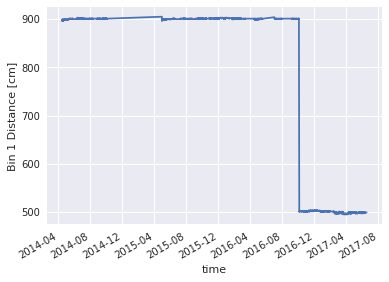

In [0]:
ds['bin_1_distance'].plot()

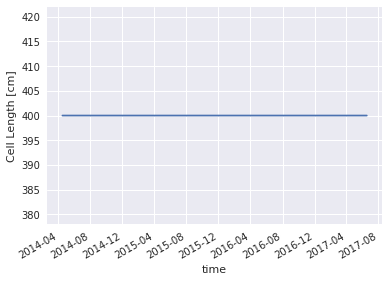

In [0]:
ds['cell_length'].plot()

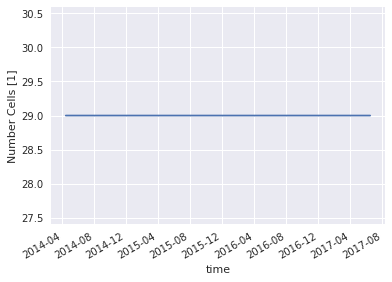

In [0]:
ds['num_cells'].plot()

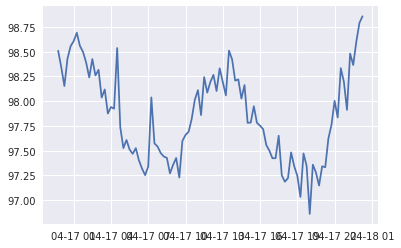

In [0]:
plt.plot(time[1:100],depth[0,1:100])

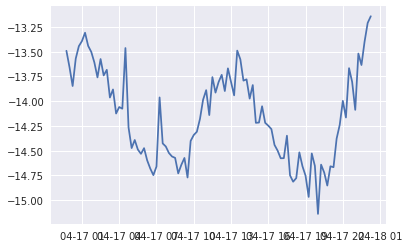

In [0]:
plt.plot(time[1:100],depth[28,1:100])

Now let's look at temperature.

In [0]:
ds['pressure'].units

'daPa'

Text(0,0.5,'Pressure [MPa]')

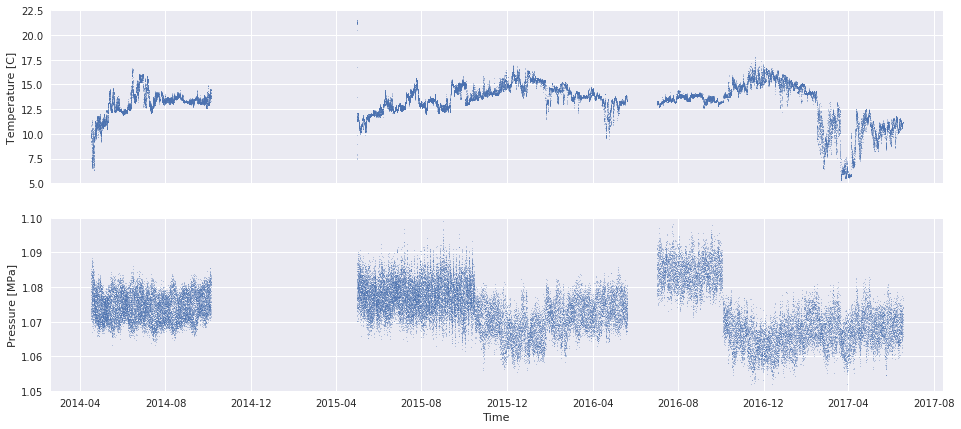

In [0]:
plt.close()
fig, axes = plt.subplots(2, sharex = True, sharey = False, figsize = (16,7))

p0 = axes[0].plot(time, temp, linestyle = 'None', marker = '.', markersize = 1)
axes[0].set_ylim(5,22.5)
axes[0].set_ylabel('Temperature [C]')

p1 = axes[1].plot(time, pres*1e-5, linestyle = 'None', marker = '.', markersize = 1)
axes[1].set_ylim(1.05,1.1)
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Pressure [MPa]')

Next, let's look at the pitch, roll, and heading of the instrument.

In [0]:
ds['pitch'].units

'deci-degrees'

In [0]:
ds['roll'].units

'deci-degrees'

In [0]:
ds['heading'].units

'deci-degrees'

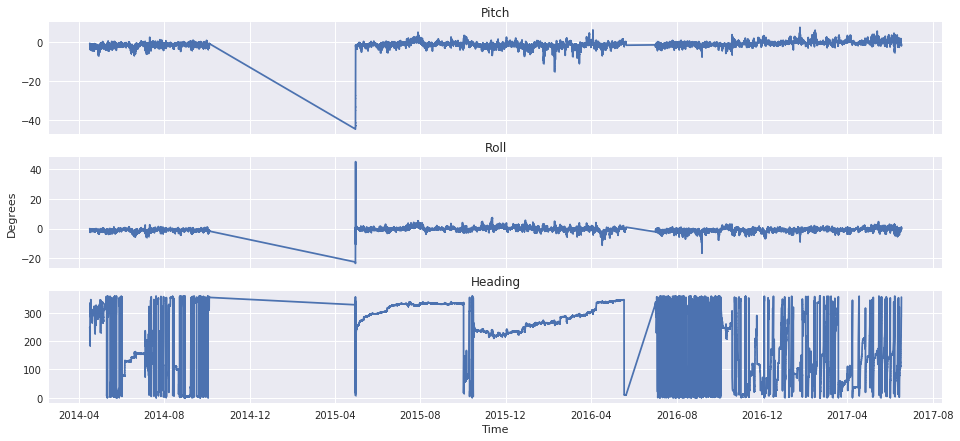

In [0]:
pitch = ds['pitch'].data/(100)
roll = ds['roll'].data/(100)
heading = ds['heading'].data/(100)

plt.close()
fig, axes = plt.subplots(3, sharex = True, sharey = False, figsize = (16,7))

p0 = axes[0].plot(time, pitch, linestyle = '-', marker = '.', markersize = 1)
axes[0].set_title('Pitch')

p1 = axes[1].plot(time, roll,linestyle='-',marker='.',markersize=1)
axes[1].set_title('Roll')
axes[1].set_ylabel('Degrees')

p2 = axes[2].plot(time, heading,linestyle='-',marker='.',markersize=1)
axes[2].set_title('Heading')
axes[2].set_xlabel('Time')

plt.show()

There is an error in the metadata. The units of the pitch, roll, and heading should be **centi-degree** instead of deci-degree. Let's look at the average value of pitch, roll, and heading.

In [0]:
pitch_ave = np.nanmean(abs(pitch))
roll_ave = np.nanmean(abs(roll))
heading_ave = np.nanmean(abs(heading))

In [0]:
pitch_ave

1.4992945

In [0]:
roll_ave

1.0450783

In [0]:
heading_ave

222.34982

Next, we are looking at the velocities obtained by the ADCP. To screen out surface noise velocities, we will set the color-bar limit to the 90th percentile of the data. Note that np.nanpercentile() is only valid if the data are normally distributed.

In [0]:
ULim = float("%2.2f" % np.nanpercentile(U, 90))
VLim = float("%2.2f" % np.nanpercentile(V, 90))
WLim = float("%2.2f" % np.nanpercentile(W, 90))
CMax = max([ULim, VLim, WLim])
CMax

0.24

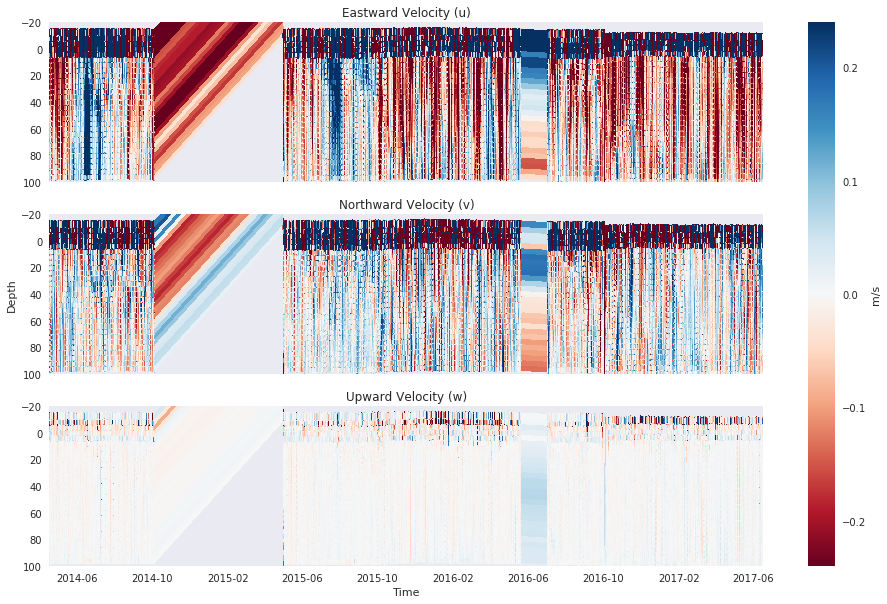

In [0]:
plt.close()
fig, axes = plt.subplots(3, sharex = True, sharey = True, figsize = (16,10))

YB = 100; YE = -20

p0 = axes[0].pcolormesh(time, depth, U, cmap = 'RdBu', vmin = -CMax, vmax = CMax)
axes[0].set_ylim(YB,YE)
axes[0].set_title('Eastward Velocity (u)')

p1 = axes[1].pcolormesh(time, depth, V, cmap = 'RdBu', vmin = -CMax, vmax = CMax)
axes[1].set_title('Northward Velocity (v)')
axes[1].set_ylabel('Depth')

p2 = axes[2].pcolormesh(time, depth, W, cmap = 'RdBu', vmin = -CMax, vmax = CMax)
axes[2].set_title('Upward Velocity (w)')
axes[2].set_xlabel('Time')

fig.colorbar(p0,ax=axes.ravel().tolist(), label='m/s')

plt.show()

As we can see from the above figure, here the ADCP obtained velocity data about 13m above the surface in the air. There is a very noisy data which should be disregarded. Moreover, as expected, the data near the surface becomes quite noisy. It should also be noted that the **depth 0m** is at the surface and the instrument located at the depth 107m.

Now we are focusing down to the deployment 7 and time period **2017,01,01 to 2017,05,01**. Thus, we first extract the bin depths, east, north, and west velocity values along the time dimensions.

In [0]:
ds1 = ds.sel(time=slice('2017-01-01 00:00:00', '2017-05-01 00:00:00'))

time_ds1 = ds1['time'].data
depth_ds1 = ds1['bin_depths'].data.T
U_ds1 = ds1['eastward_seawater_velocity'].data.T
V_ds1 = ds1['northward_seawater_velocity'].data.T
W_ds1 = ds1['upward_seawater_velocity'].data.T
temp_ds1 = ds1['temperature'].data/(100)
pres_ds1 = ds1['pressure'].data

ULim_ds1 = float("%2.2f" % np.nanpercentile(U_ds1, 90))
VLim_ds1 = float("%2.2f" % np.nanpercentile(V_ds1, 90))
WLim_ds1 = float("%2.2f" % np.nanpercentile(W_ds1, 90))
CMax_ds1 = max([ULim_ds1, VLim_ds1, WLim_ds1])
CMax_ds1

0.16

Text(0.5,0,'Time')

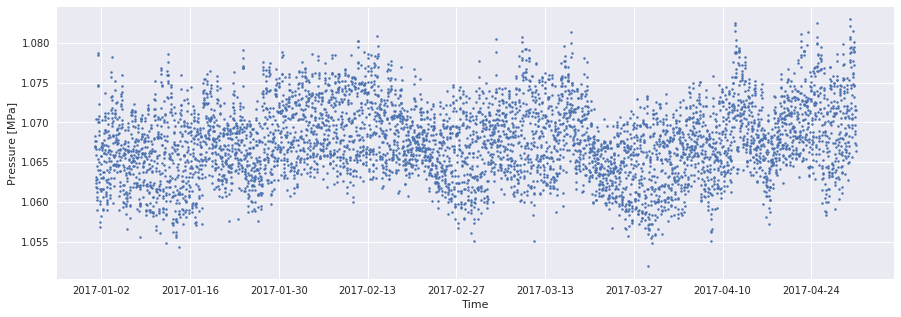

In [0]:
ax = plt.subplots(figsize = (15,5))
plt.plot(time_ds1, pres_ds1/1e5, linestyle = 'None', marker = '.', markersize = 5)
ax[1].set_ylabel('Pressure [MPa]')
ax[1].set_xlabel('Time')

Text(0.5,0,'Time')

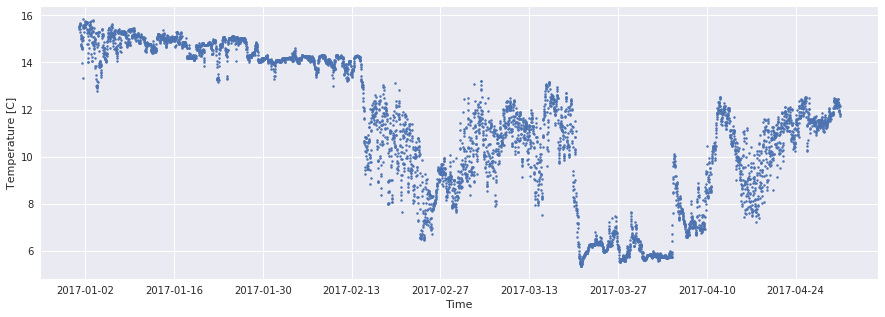

In [0]:
ax = plt.subplots(figsize = (15,5))
plt.plot(time_ds1, temp_ds1, linestyle = 'None', marker = '.', markersize = 5)
ax[1].set_ylabel('Temperature [C]')
ax[1].set_xlabel('Time')

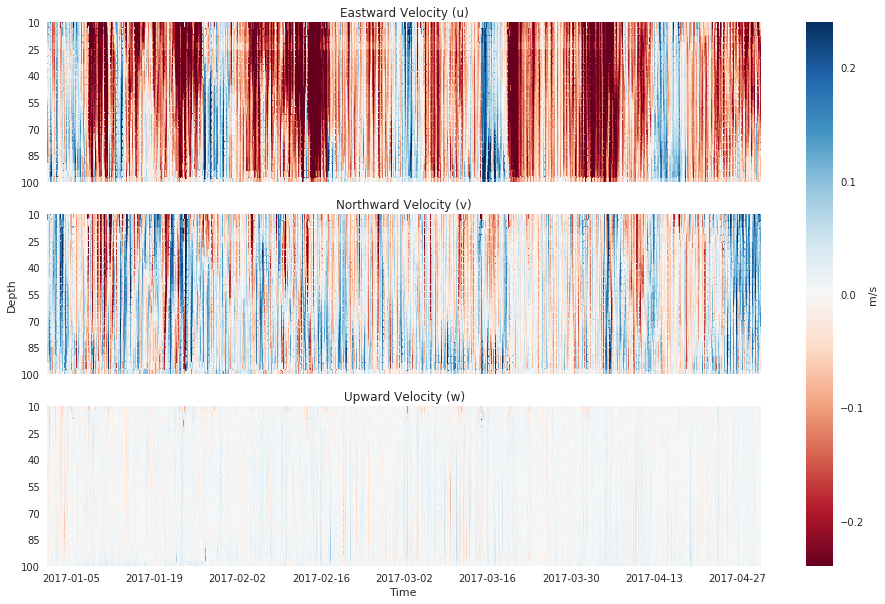

In [0]:
plt.close()
fig, axes = plt.subplots(3, sharex = True, sharey = True, figsize = (16,10))

YB = 100; YE = 10

p0 = axes[0].pcolormesh(time_ds1, depth_ds1, U_ds1, cmap = 'RdBu', vmin = -CMax, vmax = CMax)
axes[0].set_ylim(YB,YE)
axes[0].set_title('Eastward Velocity (u)')
axes[0].yaxis.set_ticks(np.arange(10, 101, 15))

p1 = axes[1].pcolormesh(time_ds1, depth_ds1, V_ds1, cmap = 'RdBu', vmin = -CMax, vmax = CMax)
axes[1].set_title('Northward Velocity (v)')
axes[1].set_ylabel('Depth')

p2 = axes[2].pcolormesh(time_ds1, depth_ds1, W_ds1, cmap = 'RdBu', vmin = -CMax, vmax = CMax)
axes[2].set_title('Upward Velocity (w)')
axes[2].set_xlabel('Time')

fig.colorbar(p0,ax=axes.ravel().tolist(), label='m/s')

plt.show()

Now let's calculate the mean and turbulence velocity fields.

In [0]:
u_mean = np.nanmean(U_ds1,axis=1)
v_mean = np.nanmean(V_ds1,axis=1)
w_mean = np.nanmean(W_ds1,axis=1)

In [0]:
u_turb = U_ds1.T - (np.ones((5761,1))*u_mean)
v_turb = V_ds1.T - (np.ones((5761,1))*v_mean)
w_turb = W_ds1.T - (np.ones((5761,1))*w_mean)

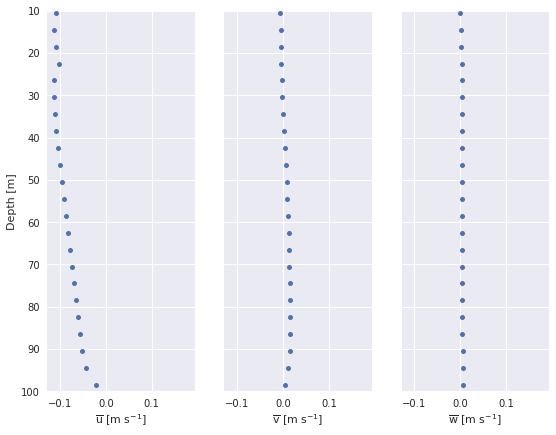

In [0]:
plt.close()
fig, axes = plt.subplots(1, 3, sharex = True, sharey = True, figsize = (9,7))

p0 = axes[0].plot(u_mean, depth[:,1], linestyle = 'none', marker = '.', markersize = 10)
axes[0].set_ylim(100,10)
axes[0].set_ylabel('Depth [m]')
axes[0].set_xlabel('$\mathrm{\overline{u}}$ [m $\mathrm{s^{-1}}$]')

p1 = axes[1].plot(v_mean, depth[:,1], linestyle = 'none', marker = '.', markersize = 10)
axes[1].set_xlabel('$\mathrm{\overline{v}}$ [m $\mathrm{s^{-1}}$]')

p2 = axes[2].plot(w_mean, depth[:,1], linestyle = 'none', marker = '.', markersize = 10)
axes[2].set_xlabel('$\mathrm{\overline{w}}$ [m $\mathrm{s^{-1}}$]')

plt.show()

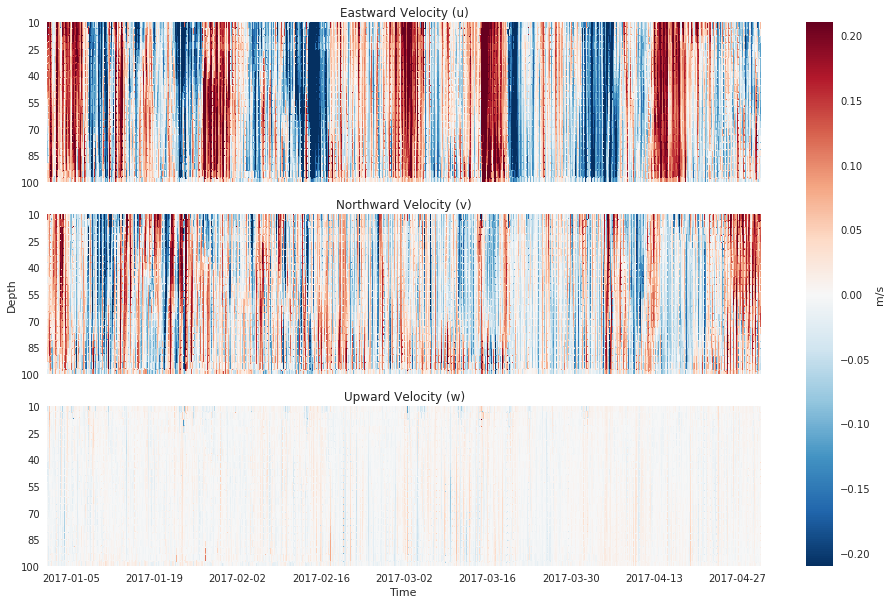

In [0]:
CTMax = max([float("%2.2f" % np.nanpercentile(u_turb, 90)),
             float("%2.2f" % np.nanpercentile(v_turb, 90)),
             float("%2.2f" % np.nanpercentile(w_turb, 90))])

plt.close()
fig, axes = plt.subplots(3, sharex = True, sharey = True, figsize = (16,10))

YB = 100; YE = 10

p0 = axes[0].pcolormesh(time_ds1, depth_ds1, u_turb.T, cmap = 'RdBu_r', vmin = -CTMax, vmax = CTMax)
axes[0].set_ylim(YB,YE)
axes[0].set_title('Eastward Velocity (u)')
axes[0].yaxis.set_ticks(np.arange(10, 101, 15))

p1 = axes[1].pcolormesh(time_ds1, depth_ds1, v_turb.T, cmap = 'RdBu_r', vmin = -CTMax, vmax = CTMax)
axes[1].set_title('Northward Velocity (v)')
axes[1].set_ylabel('Depth')

p2 = axes[2].pcolormesh(time_ds1, depth_ds1, w_turb.T, cmap = 'RdBu_r', vmin = -CTMax, vmax = CTMax)
axes[2].set_title('Upward Velocity (w)')
axes[2].set_xlabel('Time')

fig.colorbar(p0, ax = axes.ravel().tolist(), label='m/s')

plt.show()

The average of turbulent velocities should be zero. Let's plot the mean of the turbulent velocities $\overline{u^{\prime}}$, $\overline{v^{\prime}}$, and $\overline{w^{\prime}}$.

In [0]:
u_turb_mean = np.nanmean(u_turb, axis=0)
v_turb_mean = np.nanmean(v_turb, axis=0)
w_turb_mean = np.nanmean(w_turb, axis=0)

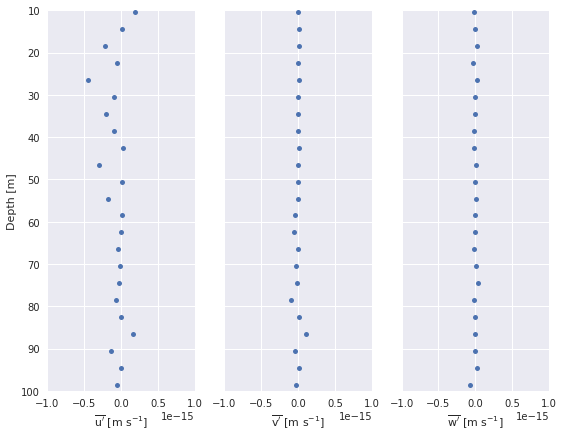

In [0]:
plt.close()
fig, axes = plt.subplots(1, 3, sharex = True, sharey = True, figsize = (9,7))

p0 = axes[0].plot(u_turb_mean, depth[:,1], linestyle = 'none', marker = '.', markersize = 10)
axes[0].set_ylim(100,10)
axes[0].set_xlim(-1e-15,1e-15)
axes[0].set_ylabel('Depth [m]')
axes[0].set_xlabel('$\mathrm{\overline{u^{\prime}}}$ [m $\mathrm{s^{-1}}$]')

p1 = axes[1].plot(v_turb_mean, depth[:,1], linestyle = 'none', marker = '.', markersize = 10)
axes[1].set_xlabel('$\mathrm{\overline{v^{\prime}}}$ [m $\mathrm{s^{-1}}$]')

p2 = axes[2].plot(w_turb_mean, depth[:,1], linestyle = 'none', marker = '.', markersize = 10)
axes[2].set_xlabel('$\mathrm{\overline{w^{\prime}}}$ [m $\mathrm{s^{-1}}$]')

plt.show()

Everything looks in a way that it should be so far, excellent! Next, we calculate the power spectral density of the turbulent velocity components.

In [0]:
from scipy import signal
from numpy import nan
import scipy.interpolate as interpolate

In [0]:
PSD_u = pd.DataFrame([])
for i in range(29):
    f, P = signal.welch(u_turb[:,i], float(1), window = 'hann', noverlap = None, nfft = len(u_turb))
    P = pd.DataFrame(P).transpose()
    PSD_u = PSD_u.append(P, ignore_index = True)
    
PSD_v = pd.DataFrame([])
for i in range(29):
    f, P = signal.welch(v_turb[:,i], float(1), window = 'hann', noverlap = None, nfft = len(u_turb))
    P = pd.DataFrame(P).transpose()
    PSD_v = PSD_v.append(P, ignore_index = True)
    
PSD_w = pd.DataFrame([])
for i in range(29):
    f, P = signal.welch(w_turb[:,i], float(1), window = 'hann', noverlap = None, nfft = len(u_turb))
    P = pd.DataFrame(P).transpose()
    PSD_w = PSD_w.append(P, ignore_index = True)

In [0]:
plt.close()
fig, axes = plt.subplots(1, 3, sharex = True, sharey = True, figsize = (17,4))

YB = 95; YE = 20

p0 = axes[0].pcolor(f, depth[0:21,0:2881], PSD_u.loc[0:20,:], vmax = 1e-3)
axes[0].set_ylim(YB,YE)
axes[0].set_ylabel('Depth [m]')
axes[0].set_title('PSD $\mathrm{U^{\prime}}$')
fig.colorbar(p0, ax = axes[0])

p1 = axes[1].pcolor(f, depth[0:21,0:2881], PSD_v.loc[0:20,:], vmax = 1e-3)
axes[1].set_title('PSD $\mathrm{V^{\prime}}$')
axes[1].set_xlabel('Frequency [Hz]')
fig.colorbar(p1, ax = axes[1])

p2 = axes[2].pcolor(f, depth[0:21,0:2881], PSD_w.loc[0:20,:], vmax = 2e-4)
axes[2].set_title('PSD $\mathrm{W^{\prime}}$')
fig.colorbar(p2, ax = axes[2])

plt.show()

In [0]:
plt.loglog(f,PSD_u.loc[15,:])
plt.ylim(1e-4,1)
plt.xlim(1e-4,1)
plt.xlabel('Frequency')
plt.ylabel('Power Spectral Density [$\mathrm{(m/s)^{2}/Hz}$]')

In [0]:
PSD_mean = np.nanmean(PSD_u, axis = 0)

plt.loglog(f,PSD_mean)
plt.ylim(1e-3,10)
plt.xlim(1e-4,1)
plt.xlabel('Frequency')
plt.ylabel('Power Spectral Density [$\mathrm{(m/s)^{2}/Hz}$]')

Finally, we are checking the signal quality parameters of the ADCP instrument. Let's plot the bad beam data.

In [0]:
BadBeams_ds1 = ds1['percent_bad_beams'].data

plt.close()
fig, axes = plt.subplots(1, sharex = True, sharey = True, figsize = (16,10))

p0 = axes.pcolormesh(time_ds1, depth_ds1, BadBeams_ds1.T, cmap = 'Blues', vmin = 0, vmax = 50)#, , vmin = -CTMax, vmax = CTMax)
axes.set_ylim(100,-15)
axes.yaxis.set_ticks(np.arange(-15, 100, 15))
axes.set_xlabel('Time')
axes.set_ylabel('Depth [m]')
axes.set_title('Percent of Bad Beams')

fig.colorbar(p0, ax = axes, label='m/s')

plt.show()

It can be clearly observed that the number of bad beams increases as we get closer to the surface. This is expected!

## 7. Conclusions
Based on this (somewhat cursory) analysis of the Coastal Pioneer Central Inshore Profiler (CP02PMCI) ADCP data, we note the following takeaways:

* In general, the temperature, pressure, and velocity field components look mostly reasonable, particularly during deployment 7.  There are no major outliers.
* The data seems to be consistent with known physical processes, though additional datasets would need to be consulted to confirm.  This includes, for example,
  * The mean vertical velocity is almost zero.
  * The mean turbulent velocity fields are almost zero.
  * The power spectral density profiles follow the typical profile for the turbulent flows.
* The percent of bad beams were also investigated where it increases as we get closer to the surface.
* There is an error in the metadata of the pitch, roll, and heading. The units of pitch, roll, and heading should be centi-degree instead of deci-degree. 
* The average value of pitch, roll, and heading was also calculated which follows the expectations.